In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os, random, sys
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [14]:
# File path to the lfw folder
path = './lfw'

In [15]:
# Build a dataloader for the dataset/folder of images that is shuffled and organized into batches of 32
transform = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform), batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [16]:
# Check if mps is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

MPS device not found.


torch.Size([250, 250, 3])


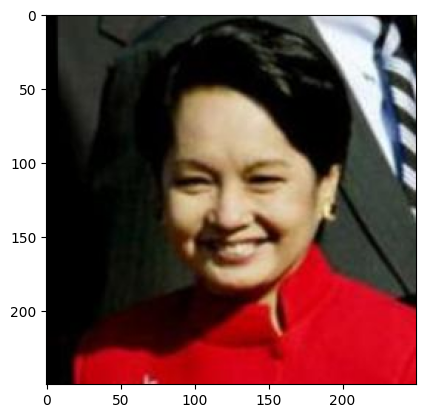

In [17]:
for x, y in dataloader:
    # Rearrange the dimensions of the first image for plotting
    x = x[0].permute(1, 2, 0)
    
    # Print the dimensions for the first image
    print(x.shape)
    
    # Plot the first image
    plt.imshow(x)
    
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [29]:
for x, y in dataloader:
    # Print the dimensions for the first image
    print('Dimensions:', x[0].shape)

    break

Dimensions: torch.Size([3, 250, 250])


The dimensions of the image tensor are (3, 250, 250). The first value represents the number of color channels, which is 3 for RGB images. The second and third values represent the height and width of the image, respectively, both being 250 pixels.  

# Step 3

Create a new pytorch model class for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create separate functions for the encoder and decoder.**

In [19]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        # Layers for the encoder
        self.encoder_layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),  # 16, 250, 250
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # 16, 125, 125
            nn.Conv2d(16, 32, 3, stride=1, padding=1),  # 32, 125, 125
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)  # 32, 62, 62
        )

        # Layers for the decoder
        self.decoder_layers = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 16, 124, 124
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # 3, 248, 248
            nn.BatchNorm2d(3),
            nn.Upsample(size=(250, 250), mode='bilinear'),  # 3, 250, 250
            nn.Sigmoid()
        )

    # Encoder function for transforming image input into a lower-dimensional representation
    def encoder(self, x):
        return self.encoder_layers(x)
    
    # Decoder function for reconstructing the original image input after the encoder
    def decoder(self, x):
        return self.decoder_layers(x)
       
    # Forward function that takes in the image input and reconstructs the image input
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [20]:
# Create an instance of the autoencoder class
model = AE()

Input Batch Shape: torch.Size([32, 3, 250, 250])
Encoded Output Shape: torch.Size([32, 32, 62, 62])
Decoded Output Shape: torch.Size([32, 3, 250, 250])


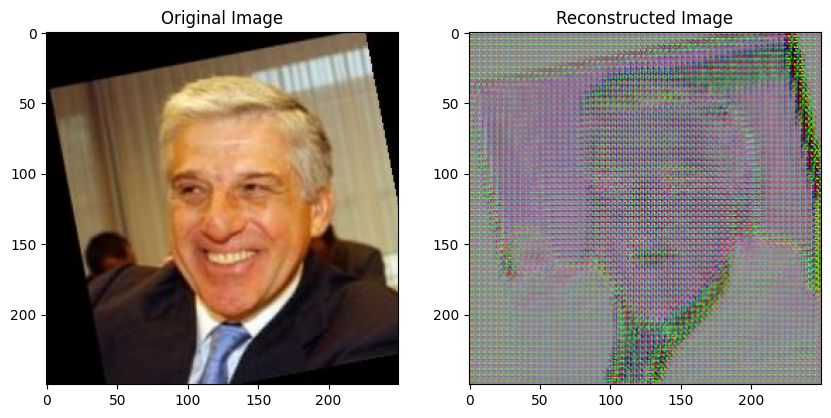

In [21]:
for images, _ in dataloader:
    # Compute the encoded output and the decoded output
    encoded_output = model.encoder(images)
    decoded_output = model.decoder(encoded_output)

    # Display the input shape, encoded output shape, and decoded output shape
    print("Input Batch Shape:", images.shape)
    print("Encoded Output Shape:", encoded_output.shape)
    print("Decoded Output Shape:", decoded_output.shape)

    # Rearrange the dimensions of the original and reconstructed image
    original_image = images[0].permute(1, 2, 0)
    reconstructed_image = decoded_output[0].detach().permute(1, 2, 0)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot the original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')

    # Plot the reconstructed image
    axes[1].imshow(reconstructed_image)
    axes[1].set_title("Reconstructed Image")

    # Show the images
    plt.show()

    break

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [22]:
# Print the total number of parameters in the model
num_params = sum(p.numel() for p in model.parameters())
print(f"Total Number of Parameters in the Model: {num_params}")

Total Number of Parameters in the Model: 10281


In [23]:
# Loss function as MSE
loss_function = nn.MSELoss()

For this task, I used Mean Squared Error (MSE) loss because it measures the difference between the image input and the reconstructed image.

In [24]:
# Use Adam as the optimizer with the model parameters
optim = optim.Adam(model.parameters())

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [25]:
# Number of epochs
num_epochs = 10

# For each epoch,
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Total loss for the epoch
    total_loss = 0.0

    # For each batch in train_loader,
    for inputs, _ in dataloader:
        # Reset gradients of model's parameters to zero
        optim.zero_grad()

        # Run the input batch through the model (getting the decoded images)
        outputs = model(inputs)

        # Calculate loss between predictions and targets using MSE
        loss = loss_function(inputs, outputs)

        # Compute gradients using backpropagation
        loss.backward()
        
        # Update model parameters using the optimizer
        optim.step()

        # Add the loss to the total loss
        total_loss += loss.item()

    # Calculate the average loss for the epoch
    average_loss = total_loss / len(dataloader)

    # Display the average loss for the given epoch
    print(f"Epoch {epoch + 1} Loss: {average_loss}")

Epoch 1 Loss: 0.018020638544787315
Epoch 2 Loss: 0.0055070883489848265
Epoch 3 Loss: 0.003108009710910186
Epoch 4 Loss: 0.0022966379503908474
Epoch 5 Loss: 0.0018508352031638836
Epoch 6 Loss: 0.0016931481530062025
Epoch 7 Loss: 0.0015898982179913543
Epoch 8 Loss: 0.001523642481871597
Epoch 9 Loss: 0.0014187715442036842
Epoch 10 Loss: 0.0013727235695254957


If the loss is not decreasing, I can tune the hyperparameters, such as the learning rate. I can also modify the complexity of the model by either making it more complex by adding layers or making it simpler by removing layers. Within these layers, I can also adjust the hyperparameters, such as the number of channels, kernel size, strides, and padding. Additionally, I can experiment with other types of layers, such as AveragePool2d, for the convolutional neural network.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

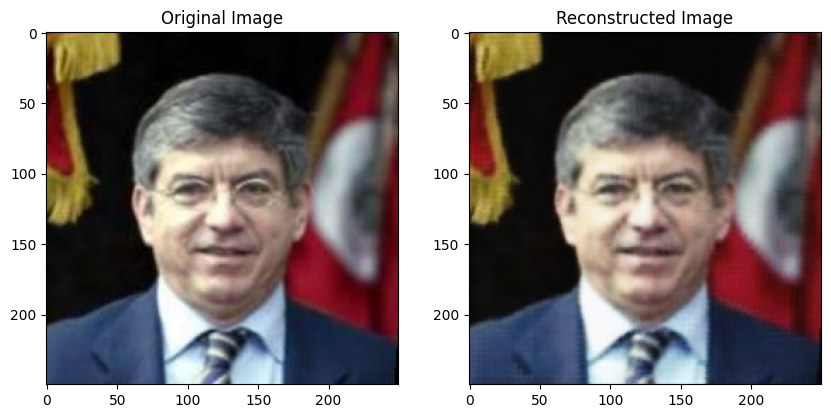

In [26]:
# Set the model to evaluation mode
model.eval()

# Initialize inputs variable from dataloader
for inputs, _ in dataloader:
    break

# Turn off gradient tracking for tensors
with torch.no_grad():
    # Run the input batch through the model (getting the decoded images)
    outputs = model(inputs)

# Rearrange the dimensions of the original and reconstructed image
original_image = inputs[0].permute(1, 2, 0)
reconstructed_image = outputs[0].permute(1, 2, 0)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

# Plot the reconstructed image
axes[1].imshow(reconstructed_image)
axes[1].set_title('Reconstructed Image')

# Show the images
plt.show()

##  Step 8

In step 7, add a small normally distributed noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

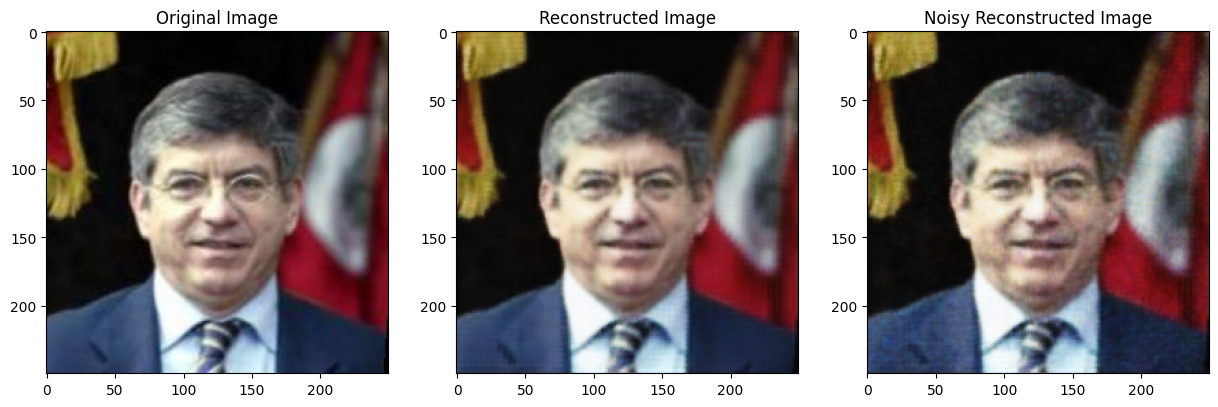

In [28]:
# Compute the latent representation of the input image
latent_representation = model.encoder(inputs)

# Compute random noise
noise = torch.randn_like(latent_representation) * 0.1

# Add noise to the latent representation
noisy_latent_representation = latent_representation + noise

# Turn off gradient tracking for tensors
with torch.no_grad():
    # Reconstruct the image using the noisy latent representation
    noisy_outputs = model.decoder(noisy_latent_representation)

# Permute the dimensions of the noisy reconstructed image
noisy_reconstructed_image = noisy_outputs[0].permute(1, 2, 0).numpy()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

# Plot the reconstructed image
axes[1].imshow(reconstructed_image)
axes[1].set_title('Reconstructed Image')

# Plot the noisy reconstructed image
axes[2].imshow(noisy_reconstructed_image)
axes[2].set_title('Noisy Reconstructed Image')

# Show plots
plt.show()

By adding a small normally distributed noise to the latent representation of the input image, the decoded image looks more blurry and not as clear as the reconstructed image without the noise.